In [91]:
import numpy as np
from tqdm.notebook import trange
from matplotlib import pyplot as plt
import scipy.stats as stats

In [107]:
np.random.seed(42)

In [109]:
np.random.random()

0.3745401188473625

In [141]:
# Define the GMM prior
def GMM_prior(x, mus, sigma2=0.1):
    """Calculate the GMM prior probability for given x1, x2 using mus and sigma."""
    prob = 0.
    for mu1, mu2 in mus:
        p1, p2 = np.exp(-((x[0] - mu1) ** 2)/(2 * sigma2)), np.exp(-((x[1] - mu2) ** 2)/(2 * sigma2))
        prob += (p1 * p2) / (2 * np.pi * sigma2)
    return prob/9
    
# Define the likelihood function
def likelihood(y, x, s_sq=2):
    """Return the likelihood of observing y given x1 and x2 with variance sigma."""
    return np.exp(-((y - x[0] - x[1])**2)/(2 * s_sq)) / np.sqrt(2 * np.pi * s_sq)

def grad_log_prior(x, m, s0_sq=0.1):
    w = np.array([np.exp(np.sum((x - mu)**2) / (-2*s0_sq)) for mu in m])
    return -np.sum(w[:, None] * (x - m), axis=0) / (s0_sq * np.sum(w))


# Define the function to calculate the graedient of the log-likelihood.
def grad_log_likelihood(y, x1, x2, sigma2=2):
    """Return the value of grad of log-prior at y given x1, x2 and sigma2."""
    return (y - x1 - x2)/sigma2

# Define the function to calcualte the gradient of the log-posterior.
def grad_log_posterior(x1, x2, y, mus):
    """Return the value of the grad of log-posterior at x1, x2 using the sum of \
        the previous 2 functions as input y and mus. """
    return grad_log_prior(np.array([x1, x2]), mus) + grad_log_likelihood(y, x1, x2)
    
# Def posterior
def log_posterior(x1, x2, y, mus):
    x = np.array([x1, x2])
    """Return the log-posterior of at x1, x2 given y, mus."""
    return np.log(GMM_prior(x, mus) * likelihood(y, x))

# Implement MALA
def MALA_sampler(y, N, burnin, mus, gamma=0.15):
    """
    Metropolis Adjusted Langevin Algorithm (MALA) to sample from posterior:
    p(x|y) ∝ p(y|x) p(x)

    Parameters
    ----------
    y : float
        Observed data point.
    N : int
        Number of MCMC iterations.
    burnin : int
        Number of burnin samples.
    mus : np.ndarray
        (9,2) array of component means for GMM prior.
    gamma : float
        Step-size for MALA.

    Returns
    -------
    samples : np.ndarray
        Array of shape (N, 2) with MCMC samples.
    accept_rate : float
        Acceptance rate of MALA proposals.
    """
    # Initialise at 0, 0
    samples = np.zeros((N+burnin, 2))
    accepts = 0

    for t in trange(1, N+burnin):
        x_curr = samples[t-1]
        grad_curr = grad_log_posterior(x_curr[0], x_curr[1], y, mus)

        # Make proposal
        x_prop = np.random.multivariate_normal(x_curr + gamma * grad_curr, 2 * gamma * np.eye(2))
        print(x_prop)
        # Compute log-posterior at current and proposed
        log_post_curr = log_posterior(x_curr[0], x_curr[1], y, mus)
        log_post_prop = log_posterior(x_prop[0], x_prop[1], y, mus)
        print(log_post_curr, log_post_prop)

        # Compute grad at proposed
        grad_prop = grad_log_posterior(x_prop[0], x_prop[1], y, mus)
        print(grad_curr, grad_prop)
        
        # calculate q(x_prop|x_curr)
        diff_prop = x_prop - (x_curr + gamma * grad_curr)
        log_q_prop = -np.sum(diff_prop**2)/(4*gamma)

        # Calculate q(x_curr | x_prop)
        diff_curr = x_curr - (x_prop + gamma * grad_prop)
        log_q_curr = -np.sum(diff_curr**2)/(4 * gamma)

        print(log_q_curr, log_q_prop)
        
        # Acceptance probability
        log_alpha = (log_post_prop - log_post_curr) + (log_q_prop - log_q_curr)
        print(log_alpha)
        alpha = np.exp(log_alpha)

        u = np.random.rand()
        if u < alpha:
            samples[t] = x_prop
            accepts += 1
        else:
            samples[t] = x_curr

    accept_rate = accepts / (N+burnin-1)
    return samples[burnin:,:], accept_rate

In [143]:
mus = np.array([[4, 0], [0, 4], [-4, 0], [0, -4], [4, 4], [4, -4], [-4, 4], [-4, -4], [0, 0]])
y = 0
N=10
burnin=0

np.random.seed(42)
samples, acc = MALA_sampler(y, N, burnin, mus)

  0%|          | 0/9 [00:00<?, ?it/s]

[ 0.27206155 -0.07573048]
-2.9980286742361644 -3.406428096627509
[0. 0.] [-2.818781    0.65913923]
-0.03877121737475682 -0.13292098339001113
-0.502549188406599
[-0.60900182  0.17466992]
-2.9980286742361644 -5.0521537249071065
[0. 0.] [ 6.30718417 -1.52953325]
-0.19436460390886642 -0.6689880001538476
-2.528748446915923
[0.86497048 0.42034131]
-2.9980286742361644 -8.03533904690985
[0. 0.] [-9.29236072 -4.84606902]
-0.6228374439099437 -1.5414345900863904
-5.955907518850133
[-0.31816006 -0.28764735]
-2.9980286742361644 -4.009613427291157
[0. 0.] [3.48450428 3.1793772 ]
-0.12940946744996792 -0.3066113664790867
-1.1887866520841115
[ 0.33704378 -0.85868752]
-4.009613427291157 -7.320770535394682
[3.48450428 3.1793772 ] [-3.10961591  8.84769705]
-1.0122330909675212 -1.859593517729599
-4.158517534865602
[ 0.65170097 -0.64540203]
-4.009613427291157 -7.20432826771764
[3.48450428 3.1793772 ] [-6.52015919  6.45087081]
-0.6200254971360115 -1.4943903131596779
-4.06907965645015
[-0.29282968 -0.58429136

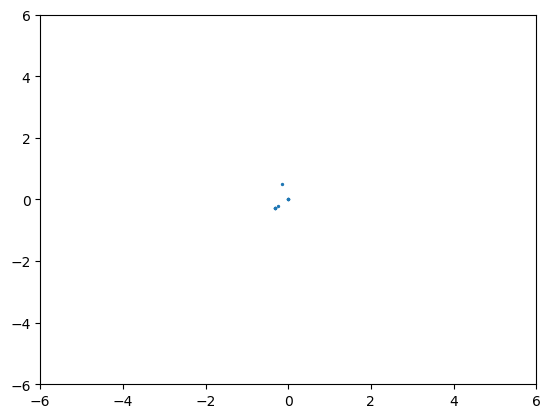

(None, 0.3333333333333333)

In [145]:
plt.scatter(samples[:, 0], samples[:, 1], s=2)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show(), acc